In [38]:
%reset -f
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pandas_profiling import ProfileReport
pd.set_option('max_columns', 10000)
pd.set_option('max_rows', 10000)
%matplotlib inline

In [39]:
engine = create_engine("sqlite:////Users/nathanieldirenzo/Documents/GitHub/NBM_EDA_Student/resources/get_mta/mta_data.db")

In [40]:
df = pd.read_sql('SELECT * FROM mta_data LIMIT 100000;', engine)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [41]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
df = df.rename(columns={'C/A': 'control_area', 'UNIT': 'unit', 'SCP': 'subunit_channel_pos', 'STATION':'station', 'LINENAME':'subway_lines', 'DIVISION':'division', 'DATE':'date', 'TIME':'time', 'DESC':'desc', 'ENTRIES':'entries', 'EXITS':'exits'})

In [43]:
df.head()

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [44]:
df['date'] = df['date'].str.replace('/','_')
df['time'] = df['time'].str.replace(':','_')
df['desc'] = df['desc'].str.replace(' ', '_')
df['subunit_channel_pos'] = df['subunit_channel_pos'].str.replace('-', '_')
df['station'] = df['station'].str.replace('-', '_')
df['station'] = df['station'].str.replace(' ', '_')

In [45]:
df['unique_id'] = df['control_area'] + '_' + df['unit'] + '_' + df['subunit_channel_pos'] + '_' + df['station'] + '_' + df['date'] + '_' + df['time'] + '_' + df['desc']

In [46]:
df['date_time'] = df.date + ' ' + df.time

In [47]:
df.date_time = pd.to_datetime(df['date_time'], format = '%m_%d_%Y %H_%M_%S')

In [48]:
df = df.set_index('unique_id')

In [49]:
df.sample(100)

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits,date_time
unique_id,,,,,,,,,,,,
A058_R001_01_00_01_WHITEHALL_S_FRY_12_19_2021_12_00_00_REGULAR,A058,R001,01_00_01,WHITEHALL_S_FRY,R1W,BMT,12_19_2021,12_00_00,REGULAR,86933,50699,2021-12-19 12:00:00
B010_R412_00_03_02_BOTANIC_GARDEN_12_21_2021_12_00_00_REGULAR,B010,R412,00_03_02,BOTANIC_GARDEN,S2345,BMT,12_21_2021,12_00_00,REGULAR,125961,826417,2021-12-21 12:00:00
B010_R412_00_00_00_BOTANIC_GARDEN_12_23_2021_12_00_00_REGULAR,B010,R412,00_00_00,BOTANIC_GARDEN,S2345,BMT,12_23_2021,12_00_00,REGULAR,311542,545262,2021-12-23 12:00:00
N012_R035_01_05_01_168_ST_12_24_2021_15_00_00_REGULAR,N012,R035,01_05_01,168_ST,AC1,IND,12_24_2021,15_00_00,REGULAR,262144,74,2021-12-24 15:00:00
A029_R082_00_00_01_28_ST_12_24_2021_11_00_00_REGULAR,A029,R082,00_00_01,28_ST,NRW,BMT,12_24_2021,11_00_00,REGULAR,6806924,8018625,2021-12-24 11:00:00
A046_R463_00_06_05_CANAL_ST_12_22_2021_20_00_00_REGULAR,A046,R463,00_06_05,CANAL_ST,JNQRZ6W,BMT,12_22_2021,20_00_00,REGULAR,786628,444765,2021-12-22 20:00:00
H041_R152_00_05_01_CANARSIE_ROCKAW_12_19_2021_08_00_00_REGULAR,H041,R152,00_05_01,CANARSIE_ROCKAW,L,BMT,12_19_2021,08_00_00,REGULAR,458752,94,2021-12-19 08:00:00
B032_R264_00_00_01_OCEAN_PKWY_12_21_2021_07_00_00_REGULAR,B032,R264,00_00_01,OCEAN_PKWY,Q,BMT,12_21_2021,07_00_00,REGULAR,41975,29509,2021-12-21 07:00:00
A077_R028_03_03_01_FULTON_ST_12_24_2021_22_00_00_REGULAR,A077,R028,03_03_01,FULTON_ST,ACJZ2345,BMT,12_24_2021,22_00_00,REGULAR,51344,73987,2021-12-24 22:00:00


In [50]:
df['net_entries'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['entries'].transform(lambda x: x.diff())
df['net_exits'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['exits'].transform(lambda x: x.diff())
df['net_traffic'] = df.net_entries + df.net_exits

In [51]:
df['net_entries'] = abs(df.net_entries)
df['net_exits'] = abs(df.net_exits)
df['net_traffic'] = abs(df.net_traffic)

In [52]:
df['audit_length_hours'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['date_time'].transform(lambda x: x.diff())

In [53]:
df['audit_length_hours'] = df.audit_length_hours.dt.total_seconds() / 3600
#df.audit_length_hours = df.audit_length_hours.fillna(df.audit_length_hours.mean())

In [54]:
df.dtypes

control_area                   object
unit                           object
subunit_channel_pos            object
station                        object
subway_lines                   object
division                       object
date                           object
time                           object
desc                           object
entries                         int64
exits                           int64
date_time              datetime64[ns]
net_entries                   float64
net_exits                     float64
net_traffic                   float64
audit_length_hours            float64
dtype: object

In [55]:
df=df.fillna(0)

In [56]:
df['avg_hourly_entries'] = df['net_entries'] / df['audit_length_hours']
df['avg_hourly_exits'] = df['net_exits'] / df['audit_length_hours']
df['avg_hourly_traffic'] = df['net_traffic'] / df['audit_length_hours']

In [57]:
df[['avg_hourly_entries', 'avg_hourly_exits', 'avg_hourly_traffic']].isna().sum()

avg_hourly_entries    2376
avg_hourly_exits      2373
avg_hourly_traffic    2373
dtype: int64

In [58]:
df = df.fillna(0)

In [59]:
df['pct_change_entries'] = df['net_entries'].pct_change() * 100
df['pct_change_exits'] = df['net_exits'].pct_change() * 100
df['pct_change_traffic'] = df['net_traffic'].pct_change() * 100

In [60]:
df[['pct_change_entries', 'pct_change_exits', 'pct_change_traffic']].isna().sum()

pct_change_entries    10010
pct_change_exits      10738
pct_change_traffic     6694
dtype: int64

In [61]:
df = df.fillna(0)

In [62]:
df['day_of_week'] = df.date_time.dt.dayofweek

In [63]:
df.head()

,control_area,unit,subunit_channel_pos,station,subway_lines,division,date,time,desc,entries,exits,date_time,net_entries,net_exits,net_traffic,audit_length_hours,avg_hourly_entries,avg_hourly_exits,avg_hourly_traffic,pct_change_entries,pct_change_exits,pct_change_traffic,day_of_week
unique_id,,,,,,,,,,,,,,,,,,,,,,,
A002_R051_02_00_00_59_ST_12_18_2021_03_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,03_00_00,REGULAR,7672966,2645023,2021-12-18 03:00:00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,5
A002_R051_02_00_00_59_ST_12_18_2021_07_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,07_00_00,REGULAR,7672969,2645040,2021-12-18 07:00:00,3.0,17.0,20.0,4.0,0.75,4.25,5.00,inf,inf,inf,5
A002_R051_02_00_00_59_ST_12_18_2021_11_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,11_00_00,REGULAR,7672991,2645127,2021-12-18 11:00:00,22.0,87.0,109.0,4.0,5.50,21.75,27.25,633.333333,411.764706,445.000000,5
A002_R051_02_00_00_59_ST_12_18_2021_15_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,15_00_00,REGULAR,7673037,2645193,2021-12-18 15:00:00,46.0,66.0,112.0,4.0,11.50,16.50,28.00,109.090909,-24.137931,2.752294,5
A002_R051_02_00_00_59_ST_12_18_2021_19_00_00_REGULAR,A002,R051,02_00_00,59_ST,NQR456W,BMT,12_18_2021,19_00_00,REGULAR,7673097,2645270,2021-12-18 19:00:00,60.0,77.0,137.0,4.0,15.00,19.25,34.25,30.434783,16.666667,22.321429,5


In [64]:
df.drop(labels=['control_area', 'unit', 'subunit_channel_pos', 'division', 'date', 'time', 'desc', 'entries', 'exits'], axis=1)

,station,subway_lines,date_time,net_entries,net_exits,net_traffic,audit_length_hours,avg_hourly_entries,avg_hourly_exits,avg_hourly_traffic,pct_change_entries,pct_change_exits,pct_change_traffic,day_of_week
unique_id,,,,,,,,,,,,,,
A002_R051_02_00_00_59_ST_12_18_2021_03_00_00_REGULAR,59_ST,NQR456W,2021-12-18 03:00:00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.000000,5
A002_R051_02_00_00_59_ST_12_18_2021_07_00_00_REGULAR,59_ST,NQR456W,2021-12-18 07:00:00,3.0,17.0,20.0,4.0,0.75,4.25,5.00,inf,inf,inf,5
A002_R051_02_00_00_59_ST_12_18_2021_11_00_00_REGULAR,59_ST,NQR456W,2021-12-18 11:00:00,22.0,87.0,109.0,4.0,5.50,21.75,27.25,633.333333,411.764706,445.000000,5
A002_R051_02_00_00_59_ST_12_18_2021_15_00_00_REGULAR,59_ST,NQR456W,2021-12-18 15:00:00,46.0,66.0,112.0,4.0,11.50,16.50,28.00,109.090909,-24.137931,2.752294,5
A002_R051_02_00_00_59_ST_12_18_2021_19_00_00_REGULAR,59_ST,NQR456W,2021-12-18 19:00:00,60.0,77.0,137.0,4.0,15.00,19.25,34.25,30.434783,16.666667,22.321429,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N502_R021_01_00_02_42_ST_BRYANT_PK_12_21_2021_07_00_00_REGULAR,42_ST_BRYANT_PK,BDFM7,2021-12-21 07:00:00,6.0,10.0,16.0,4.0,1.50,2.50,4.00,-77.777778,150.000000,-48.387097,1
N502_R021_01_00_02_42_ST_BRYANT_PK_12_21_2021_11_00_00_REGULAR,42_ST_BRYANT_PK,BDFM7,2021-12-21 11:00:00,42.0,61.0,103.0,4.0,10.50,15.25,25.75,600.000000,510.000000,543.750000,1
N502_R021_01_00_02_42_ST_BRYANT_PK_12_21_2021_15_00_00_REGULAR,42_ST_BRYANT_PK,BDFM7,2021-12-21 15:00:00,107.0,41.0,148.0,4.0,26.75,10.25,37.00,154.761905,-32.786885,43.689320,1


In [74]:
df.groupby(['station'])['net_traffic'].sum().sort_values(ascending=False)

station
BEACH_105_ST       150420617.0
42_ST_PORT_AUTH       459318.0
34_ST_PENN_STA        380507.0
14_ST_UNION_SQ        325355.0
47_50_STS_ROCK        322086.0
JKSN_HT_ROOSVLT       315377.0
CANAL_ST              290158.0
59_ST_COLUMBUS        258514.0
FULTON_ST             256234.0
34_ST_HERALD_SQ       219666.0
8_AV                  179397.0
W_4_ST_WASH_SQ        179251.0
WOODHAVEN_BLVD        166728.0
125_ST                159989.0
KINGS_HWY             157457.0
23_ST                 151933.0
JAY_ST_METROTEC       151418.0
86_ST                 143394.0
LEXINGTON_AV/53       142473.0
BEDFORD_AV            142438.0
59_ST                 142151.0
57_ST_7_AV            141530.0
CHAMBERS_ST           138103.0
KEW_GARDENS           135496.0
49_ST                 130109.0
145_ST                126999.0
1_AV                  124529.0
7_AV                  124023.0
FOREST_HILLS_71       117372.0
DEKALB_AV             116333.0
50_ST                 116220.0
CORTLANDT_ST          110149.0


In [75]:
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile

In [80]:
df.groupby('station')['net_traffic'].mean().sort_values(ascending=False)

station
BEACH_105_ST       884827.158824
34_ST_HERALD_SQ       348.676190
JKSN_HT_ROOSVLT       341.317100
145_ST                335.976190
NEWKIRK_PLAZA         297.442857
HOYT_SCHER            294.480952
MYRTLE_AV             282.869048
14_ST_UNION_SQ        271.581803
CRESCENT_ST           264.984127
45_ST                 259.714286
SUTTER_AV             254.250000
PARKSIDE_AV           253.214286
TIMES_SQ_42_ST        250.345930
CLEVELAND_ST          249.345238
MONTROSE_AV           245.731707
ATL_AV_BARCLAY        232.502381
125_ST                231.532562
HIGH_ST               228.250000
59_ST_COLUMBUS        228.167696
W_4_ST_WASH_SQ        223.504988
WOODHAVEN_BLVD        220.539683
NEW_LOTS              220.073171
42_ST_PORT_AUTH       214.434174
47_50_STS_ROCK        213.726609
7_AV                  210.923469
GATES_AV              207.031746
BOWERY                204.682540
53_ST                 200.922619
CLASSON_AV            199.269841
SHEEPSHEAD_BAY        197.798942
JF

In [68]:
agg_df

station
BEACH_105_ST       22122.424894
34_ST_HERALD_SQ       87.169048
JKSN_HT_ROOSVLT       85.329275
145_ST                83.994048
NEWKIRK_PLAZA         74.360714
HOYT_SCHER            73.620238
14_ST_UNION_SQ        71.885165
MYRTLE_AV             70.717262
CRESCENT_ST           66.246032
TIMES_SQ_42_ST        65.239861
45_ST                 64.928571
SUTTER_AV             63.562500
PARKSIDE_AV           63.303571
CLEVELAND_ST          62.336310
125_ST                60.897543
MONTROSE_AV           58.854675
ATL_AV_BARCLAY        58.125595
HIGH_ST               57.062500
59_ST_COLUMBUS        57.004082
W_4_ST_WASH_SQ        56.565275
WOODHAVEN_BLVD        55.134921
NEW_LOTS              54.508130
42_ST_PORT_AUTH       53.608543
47_50_STS_ROCK        53.431652
7_AV                  52.730867
GATES_AV              51.757937
BOWERY                51.170635
53_ST                 50.230655
CLASSON_AV            49.817460
SHEEPSHEAD_BAY        49.449735
JFK_JAMAICA_CT1       49.144015


In [69]:
nta_map = gpd.read_file('/Users/nathanieldirenzo/Documents/GitHub/NYC_MTA_EDA_Project/nynta2020.shp')
nta_map.head()
nta_map.to_crs(4326, inplace=True)
nta_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

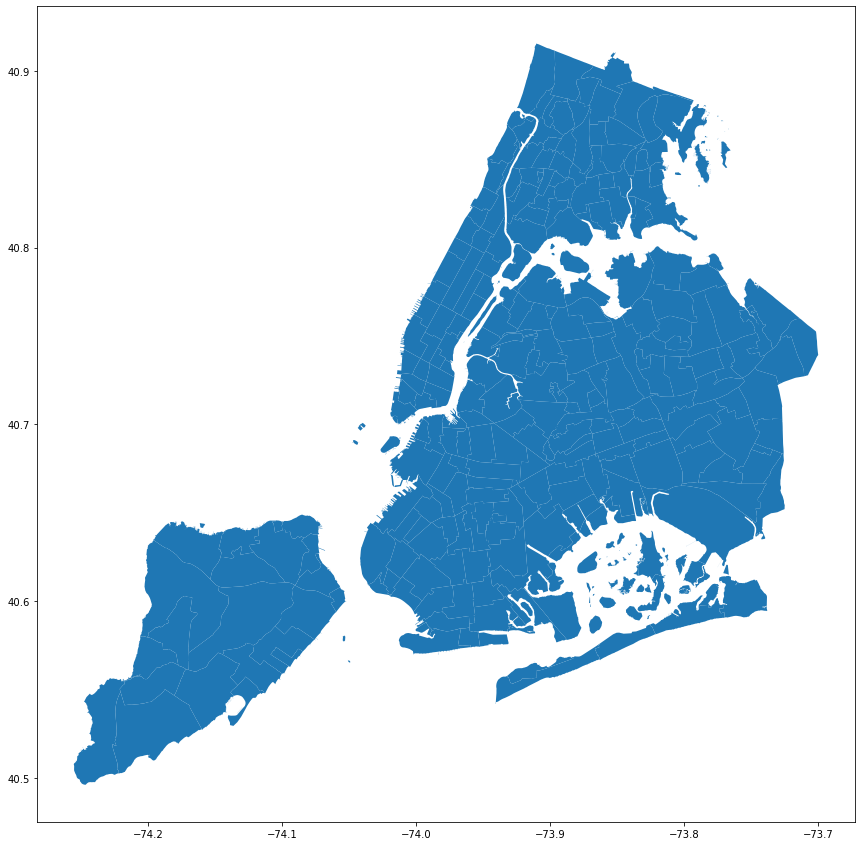

In [70]:
fig,ax = plt.subplots(figsize=(15,15))
nta_map.plot(ax=ax)
plt.show()

In [71]:
station_df = gpd.read_file('Subway Stations.geojson')
station_df

,name,url,line,objectid,notes,geometry
0,Astor Pl,http://web.mta.info/nyct/service/,4-6-6 Express,1,"4 nights, 6-all times, 6 Express-weekdays AM s...",POINT (-73.99107 40.73005)
1,Canal St,http://web.mta.info/nyct/service/,4-6-6 Express,2,"4 nights, 6-all times, 6 Express-weekdays AM s...",POINT (-74.00019 40.71880)
2,50th St,http://web.mta.info/nyct/service/,1-2,3,"1-all times, 2-nights",POINT (-73.98385 40.76173)
3,Bergen St,http://web.mta.info/nyct/service/,2-3-4,4,"4-nights, 3-all other times, 2-all times",POINT (-73.97500 40.68086)
4,Pennsylvania Ave,http://web.mta.info/nyct/service/,3-4,5,"4-nights, 3-all other times",POINT (-73.89489 40.66471)
5,238th St,http://web.mta.info/nyct/service/,1,6,"1-all times, exit only northbound",POINT (-73.90087 40.88467)
6,Cathedral Pkwy (110th St),http://web.mta.info/nyct/service/,A-B-C,7,"A-nights, B-weekdays and evenings, C-all times...",POINT (-73.95807 40.80058)
7,Kingston - Throop Aves,http://web.mta.info/nyct/service/,A-C,8,"A-nights, C-all other times",POINT (-73.94086 40.67992)
8,65th St,http://web.mta.info/nyct/service/,E-M-R,9,"E-nights, R-all other times, M-weekdays and ev...",POINT (-73.89879 40.74972)
9,36th St,http://web.mta.info/nyct/service/,E-M-R,10,"E-nights, R-all other times, M-weekdays and ev...",POINT (-73.92902 40.75196)


AttributeError: 'GeoDataFrame' object has no attribute 'geomtery'

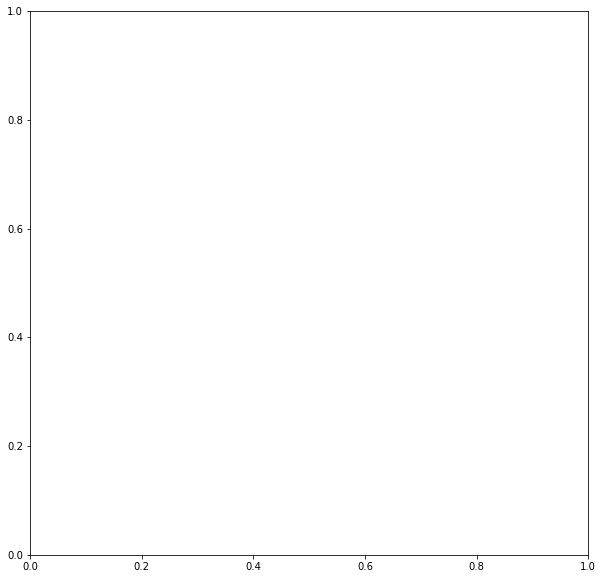

In [72]:
fig,ax = plt.subplots(figsize=(10,10))
station_df.geomtery.plot(ax=ax, markersize=20, color='blue', marker='o', label = 'Station')

In [ ]:
fig,ax = plt.subplots(figsize=(20,20))
nta_map.plot(ax=ax,)
geo_df.plot(ax=ax, markersize=20, color='red', marker='o', label = 'Station')